In [ ]:
# imports

import sys
sys.path.append("//home/a.jajodia.229/acoustic/acoustic_knowledge_discovery")


import librosa

from tqdm.notebook import tqdm
from random import sample
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn import svm, neighbors, model_selection, manifold
from statistics import mean
from sklearn.metrics import classification_report
from skimage.measure import block_reduce

# import tensorflow_hub as hub
# import tensorflow as tf

from egci_spectrograms_clustering.utils import *
from pyha_analyzer import extractors
from pyha_analyzer.preprocessors import MelSpectrogramPreprocessors

In [16]:
# getting all the wavs

preprocessor = MelSpectrogramPreprocessors(duration=5)
music_extractor = extractors.Music()
music_ads = music_extractor("/home/a.jajodia.229/acoustic/local_data/muha/Liked Sounds/Location A Sand Forrest")

music_ads['train'].set_transform(preprocessor)

Casting the dataset:   0%|          | 0/498 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/64 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

In [3]:
df = music_ads['train'].to_pandas()
df['dataset'] = 'Muha'

In [18]:
music_ads['train'][0]

{'sample_rate': 96000,
 'labels': array([1., 0.], dtype=float32),
 'filepath': '/home/a.jajodia.229/acoustic/local_data/muha/Liked Sounds/Location A Sand Forrest/Zoom_F3/030525_003_20250503_174500_part_017.wav',
 'audio': array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.00392157, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.00392157, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]], shape=(1, 256, 431), dtype=float32),
 'audio_in': array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.    

In [ ]:
data = [get_egci(df.iloc[i]) for i in tqdm(range(200)) if get_egci(df.iloc[i]) is not None]
data = sum(data,[])

  0%|          | 0/200 [00:00<?, ?it/s]

no audio here :(


no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here :(
no audio here 

TypeError: sum() can't sum strings [use ''.join(seq) instead]

In [16]:
metadata = pd.read_csv('/home/a.jajodia.229/acoustic/local_data/muha/Liked Sounds/Location A Sand Forrest/Metadat -  Sandforest.csv', delimiter=';')

In [ ]:
data['time'] = data['path'].str.split('_').apply(lambda x: ('Night' if ((int(x[5]) > 180000) or (int(x[5]) < 60000)) else 'Day') if (len(x) == 8) else pd.NA)
sns.scatterplot(data, x = 'entropy', y = 'complexity', hue = 'time')

In [3]:
sr = 96000
max_length = sr*4 # ignore samples longer than 4 seconds
fixed_length = sr/4 # trim all samples to 250 milliseconds
limit = None # set this to 100 to only load the first 100 samples

In [4]:
def load_sample(fn, sr=None,
                max_length=None, fixed_length=None, normalize=True):
    if fn == '': # ignore empty filenames
        return None
    audio, _ = librosa.load(fn)
    duration = len(audio)
    if duration == 0: # ignore zero-length samples
        return None
    if max_length and duration >= max_length: # ignore long samples
        return None
    if fixed_length:
        np.resize(audio, fixed_length)
    max_val = np.abs(audio).max()
    if max_val == 0: # ignore completely silent sounds
        return None
    if normalize:
        audio /= max_val
    return (fn, audio, duration)

In [5]:
max_length = sr*4 # ignore samples longer than 4 seconds
fixed_length = sr//4 # trim all samples to 250 milliseconds
limit = None # set this to 100 to only load the first 100 samples

In [8]:
sample = [load_sample(filepath, max_length=max_length, fixed_length=fixed_length) for filepath in df['filepath']]

samples = [i[1] for i in sample if i is not None]

In [9]:
n_fft = 128
hop_length = int(n_fft/4)
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = 100 # set this to 100 to only process 100 samples

window = np.hanning(n_fft)
def job(y):
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    amp = np.abs(S)
    # if reduce_rows > 1 or reduce_cols > 1:
    #     amp = block_reduce(amp, (reduce_rows, reduce_cols), func=np.mean)
    if amp.shape[1] < crop_cols:
        amp = np.pad(amp, ((0, 0), (0, crop_cols-amp.shape[1])), 'constant')
    amp = amp[:crop_rows, :crop_cols]
    if use_logamp:
        amp = librosa.logamplitude(amp**2)
    amp -= amp.min()
    if amp.max() > 0:
        amp /= amp.max()
    amp = np.flipud(amp) # for visualization, put low frequencies on bottom
    return amp
pool = Pool()
fingerprints = pool.map(job, samples[:limit])
fingerprints = np.asarray(fingerprints).astype(np.float32)

In [10]:
# get 2d embeddings
tsne = manifold.TSNE(random_state = 1, n_components=2, learning_rate=50)
data2d = tsne.fit_transform(fingerprints.reshape((100,1024)))

data2d -= data2d.min(axis=0)
data2d /= data2d.max(axis=0)

In [ ]:
from egci_spectrograms_clustering.utils import spectrogram_grid

In [13]:
spectrogram = spectrogram_grid(data2d, paths=df['filepath'])

UnboundLocalError: cannot access local variable 'data2d' where it is not associated with a value

<Figure size 400x400 with 0 Axes>

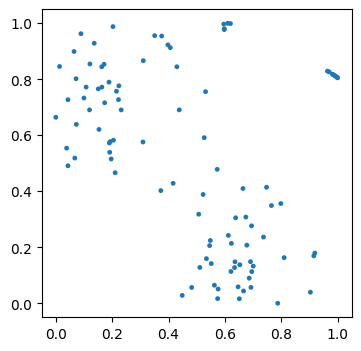

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(data2d[:,0], data2d[:,1], edgecolors='none', marker='o', s=12)
plt.show()

side = 10
xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
grid = np.dstack((xv, yv)).reshape(-1, 2)

In [ ]:
from scipy.spatial.distance import cdist
cost = cdist(grid, data2d, 'sqeuclidean')
cost = cost * (10000000. / cost.max())

(100,)


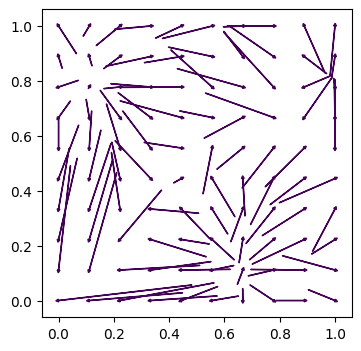

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.viridis
norm = Normalize(vmin=0, vmax=3) # Adjust vmin/vmax based on your data range

min_cost, row_assigns, col_assigns = lap.lapjv(np.copy(cost))
grid_jv = grid[col_assigns]
print(col_assigns.shape)
plt.figure(figsize=(4, 4))
for index, (start, end) in enumerate(zip(data2d, grid_jv)):
    arrow_color = cmap(1)
    
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01, fc=arrow_color, ec=arrow_color)
plt.show()

In [ ]:
# data_trimmed = [i[:,:,0:1876] for i in data['audio']]

In [ ]:
coords

array([[6, 9],
       [2, 6],
       [5, 1],
       [0, 0],
       [8, 4],
       [4, 4],
       [9, 9],
       [8, 5],
       [4, 0],
       [2, 1],
       [2, 6],
       [5, 8],
       [5, 2],
       [2, 5],
       [6, 6],
       [6, 0],
       [6, 8],
       [9, 6],
       [3, 4],
       [3, 3],
       [6, 5],
       [5, 0],
       [9, 3],
       [4, 6],
       [6, 8],
       [1, 6],
       [8, 3],
       [6, 1],
       [9, 4],
       [0, 5],
       [1, 2],
       [2, 3],
       [3, 8],
       [1, 6],
       [0, 4],
       [6, 2],
       [6, 6],
       [4, 1],
       [0, 1],
       [2, 2],
       [0, 2],
       [3, 9],
       [4, 8],
       [3, 1],
       [6, 6],
       [5, 6],
       [6, 1],
       [4, 3],
       [2, 9],
       [6, 9],
       [9, 8],
       [3, 0],
       [6, 4],
       [1, 0],
       [8, 9],
       [8, 1],
       [3, 2],
       [9, 1],
       [1, 4],
       [0, 6],
       [5, 5],
       [1, 1],
       [8, 6],
       [5, 4],
       [5, 3],
       [6, 4],
       [6,

[[6 9]
 [2 6]
 [5 1]
 [0 0]
 [8 4]
 [4 4]
 [9 9]
 [8 5]
 [4 0]
 [2 1]
 [2 6]
 [5 8]
 [5 2]
 [2 5]
 [6 6]
 [6 0]
 [6 8]
 [9 6]
 [3 4]
 [3 3]
 [6 5]
 [5 0]
 [9 3]
 [4 6]
 [6 8]
 [1 6]
 [8 3]
 [6 1]
 [9 4]
 [0 5]
 [1 2]
 [2 3]
 [3 8]
 [1 6]
 [0 4]
 [6 2]
 [6 6]
 [4 1]
 [0 1]
 [2 2]
 [0 2]
 [3 9]
 [4 8]
 [3 1]
 [6 6]
 [5 6]
 [6 1]
 [4 3]
 [2 9]
 [6 9]
 [9 8]
 [3 0]
 [6 4]
 [1 0]
 [8 9]
 [8 1]
 [3 2]
 [9 1]
 [1 4]
 [0 6]
 [5 5]
 [1 1]
 [8 6]
 [5 4]
 [5 3]
 [6 4]
 [6 5]
 [6 6]
 [8 2]
 [0 9]
 [1 8]
 [3 5]
 [9 5]
 [1 9]
 [6 3]
 [4 2]
 [8 0]
 [0 8]
 [9 6]
 [1 3]
 [1 5]
 [8 6]
 [4 6]
 [4 5]
 [9 0]
 [2 8]
 [6 0]
 [3 6]
 [8 8]
 [9 2]
 [2 0]
 [3 6]
 [2 4]
 [4 9]
 [6 2]
 [0 3]
 [5 6]
 [0 6]
 [6 3]
 [5 9]]


/tmp/ipykernel_3912015/3250165404.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ax, item in tqdm_notebook(zip(grid, images)):


0it [00:00, ?it/s]

/home/a.jajodia.229/acoustic/acoustic_knowledge_discovery/.venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


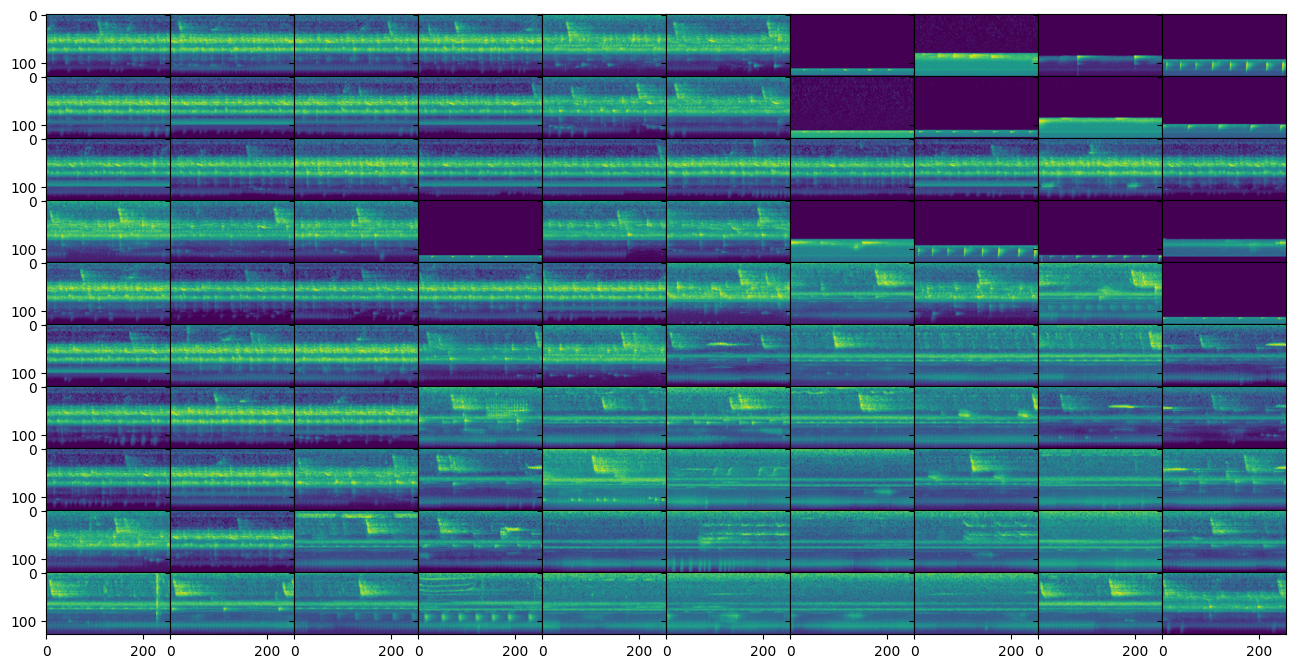

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import torch

from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm_notebook


fig = plt.figure(figsize=(16., 16.))

coords = (grid_jv*9).astype(int)

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 10),
                 axes_pad=0,  # pad between Axes in inch.
                 )

indexes = np.lexsort((coords[:, 0], -coords[:, 1]))

print(coords)

images = np.array(data['path'])[indexes]

for ax, item in tqdm_notebook(zip(grid, images)):
    # spectrogram_tensor = torch.tensor(item, dtype=torch.float32)
    # im = spectrogram_tensor.squeeze(0).numpy()  # shape: (H, W)
    
    
    y, sr = librosa.load(item, sr = None)
    im = librosa.feature.melspectrogram(y=y, sr=sr)

    im = librosa.power_to_db(im, ref=np.max)
    
    im = im[:,0:256]
    
    # print(im)  # Optionally print for debugging
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    
plt.show()

In [ ]:
import IPython

def play_from_grid(x,y, data):
    filepath = data[indexes.reshape((10,10))][9-y,x]
    
    
    print(filepath)
    
    fig = plt.figure(figsize=(8., 8.))
    
    ax = fig.gca()
    
    # spectrogram_tensor = torch.tensor(audio, dtype=torch.float32)
    # im = spectrogram_tensor.squeeze(0).numpy()  # shape: (H, W)
    # im = im / im.mean()
    
    # ax.imshow(im)
    
    y, sr = librosa.load(filepath, sr = None)
    im = librosa.feature.melspectrogram(y=y, sr=sr)

    im = librosa.power_to_db(im, ref=np.max)
    
    
    print(im.shape)
    im = im[:,0:939]
    
    # print(im)  # Optionally print for debugging
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    
    display(IPython.display.Audio(filepath, autoplay=True))
    
    
    
    return None

/home/a.jajodia.229/acoustic/local_data/muha/Liked Sounds/Location A Sand Forrest/Zoom_F3/030525_005_20250503_192700_part_120.wav
(128, 939)


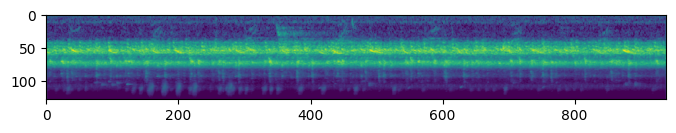

In [ ]:
play_from_grid(5, 5, images)

In [ ]:
data.to_csv('/home/a.jajodia.229/acoustic/acoustic_knowledge_discovery/egci_spectrograms_clustering/muha_data.csv', index=False)

In [ ]:
# data['x'] = [coord[0] for coord in coords]
# data['y'] = [coord[1] for coord in coords]

